In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import pickle 
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks_cwt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
plt.figure(figsize=(10,8))

In [2]:
def display(image):
    plt.imshow(image),plt.show()

In [3]:
def getCalibrationImages():
    images = glob.glob('camera_cal/calibration*.jpg')
    return images

In [4]:
def getObjImgpoints():
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = getCalibrationImages()
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    return objpoints,imgpoints

In [5]:
def getCalibrationImgSize():
    img = cv2.imread("camera_cal/calibration2.jpg")
    img_size = (img.shape[1], img.shape[0])
    return img_size

In [6]:
def calibrateCamera():
    objpoints,imgpoints = getObjImgpoints()
    img_size = getCalibrationImgSize()
    _, mtx, dist,_,_ = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return mtx,dist

In [7]:
def undistort(image):
    mtx,dist = calibrateCamera()
    undist_img = cv2.undistort(image, mtx, dist, None, mtx)
    return undist_img

In [8]:
def testundistort():
    img = cv2.imread("camera_cal/calibration2.jpg")
    img2 = undistort(img)
    display(img)
    display(img2)
    
    imgRGB = cv2.cvtColor(cv2.imread("test_images/test3.jpg"), cv2.COLOR_BGR2RGB)
    img2 = undistort(imgRGB)
    display(imgRGB)
    display(img2)

In [9]:
def gettestimage():
    return(cv2.cvtColor(cv2.imread("test_images/test3.jpg"), cv2.COLOR_BGR2RGB))

In [10]:
def warp_image(img,src,dst,img_size):
    # Apply perspective transform
    M      = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv   = cv2.getPerspectiveTransform(dst, src)

    return warped,Minv

In [11]:
def apply_perspective_transform(image):
    # Applies bird-eye perspective transform to an image
    height,width = image.shape[0],image.shape[1]
    
    Topleftpoint     = [np.uint(width/2) - .25*np.uint(width/2),np.uint(height/1.5)]
    Toprightpoint    = [np.uint(width/2) + .25*np.uint(width/2),np.uint(height/1.5)]
    Bottomleftpoint  = [0                                      ,np.uint(height)    ]
    Bottomrightpoint = [np.uint(width)                         ,np.uint(height)    ]

    src              = np.float32([Bottomleftpoint,Bottomrightpoint,Toprightpoint,Topleftpoint])
    dst              = np.float32([[0,height]     ,[width,height]  ,[width,0]    ,[0,0]       ])
    
    warped,Minv_warp = warp_image(image,src,dst,(width,height)) # returns birds eye image
    
    return warped,Minv_warp


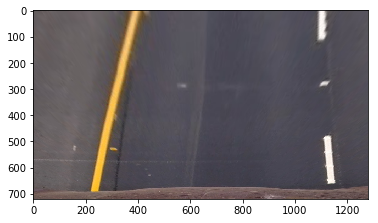

In [12]:
warped,_ =apply_perspective_transform(gettestimage())
display(warped)

In [13]:
def blur(image,kernel_size = 5):
    blur = cv2.GaussianBlur(image,(kernel_size,kernel_size),0)
    return blur

In [14]:
def RGB2HSV(image):
    return(cv2.cvtColor(image,cv2.COLOR_RGB2HSV))

In [15]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output

In [16]:
def color_mask(hsv,low,high):
    # Takes in low and high values and returns mask
    mask = cv2.inRange(hsv, low, high)
    return mask

In [17]:
def apply_color_mask(hsv,img,low,high):
    # Takes in color mask and returns image with mask applied.
    mask = color_mask(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

In [18]:
def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [19]:
def get_curvature(pol_a,y_pt):
    # Returns curvature of a quadratic
    A = pol_a[0]
    B = pol_a[1]
    R_curve = (1+(2*A*y_pt+B)**2)**1.5/2/A
    return R_curve

In [20]:
def stack_arr(arr):
    # Stacks 1-channel array into 3-channel array to allow plotting
    return np.stack((arr, arr,arr), axis=2)

In [21]:
def yellowmask():
    return np.array([ 0, 100, 100]),np.array([ 50, 255, 255])

In [22]:
def whitemask():
    return  np.array([ 20, 0, 180]),np.array([ 255,  80, 255])

In [23]:
def combine(mask1,mask2):
    return cv2.bitwise_or(mask1,mask2)

In [24]:
def get_initial_mask(img,window_sz):
    
    # This function gets the initial mask
    
    img = blur(img,5)
    height       = np.shape(img)[0]
    width        = np.shape(img)[1]
    mov_filtsize = width/50.
    mean_ln      = np.mean(img[height/2:,:],axis=0)
    mean_ln      = moving_average(mean_ln,mov_filtsize)
    
    indexes = find_peaks_cwt(mean_ln,[100], max_distances=[800])

    val_ind = np.array([mean_ln[indexes[i]] for i in range(len(indexes)) ])
    ind_sorted = np.argsort(-val_ind)

    ind_peakR = indexes[ind_sorted[0]]
    ind_peakL = indexes[ind_sorted[1]]
    if ind_peakR<ind_peakL:
        ind_temp = ind_peakR
        ind_peakR = ind_peakL
        ind_peakL = ind_temp

    n_vals = 8
    ind_min_L = ind_peakL-window_sz
    ind_max_L = ind_peakL+window_sz

    ind_min_R = ind_peakR-window_sz
    ind_max_R = ind_peakR+window_sz

    mask_L_i = np.zeros_like(img)
    mask_R_i = np.zeros_like(img)

    ind_peakR_prev = ind_peakR
    ind_peakL_prev = ind_peakL
    
    # Split image into 8 parts and compute histogram on each part
    
    for i in range(8):
        img_y1 = height-height*i/8
        img_y2 = height-height*(i+1)/8
    
        mean_lane_y = np.mean(img[img_y2:img_y1,:],axis=0)
        mean_lane_y = moving_average(mean_lane_y,mov_filtsize)
        indexes = find_peaks_cwt(mean_lane_y,[100], max_distances=[800])
        
        if len(indexes)>1.5:
            val_ind = np.array([mean_ln[indexes[i]] for i in range(len(indexes)) ])
            ind_sorted = np.argsort(-val_ind)

            ind_peakR = indexes[ind_sorted[0]]
            ind_peakL = indexes[ind_sorted[1]]
            if ind_peakR<ind_peakL:
                ind_temp = ind_peakR
                ind_peakR = ind_peakL
                ind_peakL = ind_temp
            
        else:
        # If no pixels are found, use previous ones. 
            if len(indexes)==1:
                if (np.abs(indexes[0]-ind_peakR_prev)<np.abs(indexes[0]-ind_peakL_prev)):
                    ind_peakR = indexes[0]
                    ind_peakL = ind_peakL_prev
                else:
                    ind_peakL = indexes[0]
                    ind_peakR = ind_peakR_prev
            else:
                ind_peakL = ind_peakL_prev
                ind_peakR = ind_peakR_prev
            
            
        # If new center is more than 60pixels away, use previous
        # Outlier rejection
        if np.abs(ind_peakL-ind_peakL_prev)>=60:
            ind_peakL = ind_peakL_prev

        if np.abs(ind_peakR-ind_peakR_prev)>=60:
            ind_peakR = ind_peakR_prev
            
    
            
        mask_L_i[img_y2:img_y1,ind_peakL-window_sz:ind_peakL+window_sz] = 1.
        mask_R_i[img_y2:img_y1,ind_peakR-window_sz:ind_peakR+window_sz] = 1.
        
        ind_peakL_prev = ind_peakL
        ind_peakR_prev = ind_peakR
        
    return mask_L_i,mask_R_i

In [25]:
def get_mask_poly(img,poly_fit,window_sz):
    
    # This function returns masks for points used in computing polynomial fit. 
    mask_poly = np.zeros_like(img)
    height,width = np.shape(img)[0],np.shape(img)[1]

    poly_pts = []
    pt_y_all = []

    for i in range(8):
        img_y1 = height-height*i/8
        img_y2 = height-height*(i+1)/8

        pt_y = (img_y1+img_y2)/2
        pt_y_all.append(pt_y)
        poly_pt = np.round(poly_fit[0]*pt_y**2 + poly_fit[1]*pt_y + poly_fit[2])
    
        poly_pts.append(poly_pt)
    
        mask_poly[img_y2:img_y1,poly_pt-window_sz:poly_pt+window_sz] = 1.     

    return mask_poly, np.array(poly_pts),np.array(pt_y_all)
    

In [26]:
def get_val(y,pol_a):
    # Returns value of a quadratic polynomial 
    return pol_a[0]*y**2+pol_a[1]*y+pol_a[2]

def draw_pw_lines(img,pts,color):
    # This function draws lines connecting 10 points along the polynomial
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)

In [ ]:
def process(image):
    global left_fit_prev   
    global right_fit_prev
    global col_R_prev
    global col_L_prev
    global set_prev
    global mask_poly_L
    global mask_poly_R
    global window_size
    window_size=60
    
    image     = undistort(image)
    image     = blur(image)
    warped,Minv_warp    = apply_perspective_transform(image)
    image_HSV = RGB2HSV(warped)
    height,width = np.shape(image)[0],np.shape(image)[1]

    
    yellow_hsv_low, yellow_hsv_high  = yellowmask()
    white_hsv_low, white_hsv_high    = whitemask()
    
    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    
    mask_lane=combine(mask_yellow,mask_white)
    
    image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

    # Apply sobel filters on L and S channels.
    img_gs = image_HLS[:,:,1]    #1- Stands for L Channel
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
    wraped2 = np.copy(combine(img_abs_x,img_abs_y))
    
    img_gs = image_HLS[:,:,2]    #2- Stands for S Channel
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))
    wraped3 = np.copy(combine(img_abs_x,img_abs_y))

    
    # Combine sobel filter information from L and S channels.
    image_cmb = combine(wraped2,wraped3)
    image_cmb = blur(image_cmb,25)
    
    image_cmb1 = np.zeros_like(image_cmb)
    image_cmb1[(mask_lane>=.5)|(image_cmb>=.5)]=1
    
    if set_prev == 0:
        image_cmb1 = blur(image_cmb1)
        mask_poly_L,mask_poly_R = get_initial_mask(image_cmb1,40)
        
    # Define all colors as white to start.         
    col_R = (255,255,255)
    col_L = (255,255,255)
    col_R = (255,255,255)
    col_L = (255,255,255)
    
    # Apply mask to sobel images and compute polynomial fit for left. 
    img_L = np.copy(image_cmb1)
    img_L = cv2.bitwise_and(image_cmb1,image_cmb1,
                                mask = mask_poly_L)
    vals = np.argwhere(img_L>.5)
    if len(vals)<5: ## If less than 5 points 
        left_fit = left_fit_prev
        col_L = col_L_prev
    else:
        all_x = vals.T[0]
        all_y =vals.T[1]
        left_fit = np.polyfit(all_x, all_y, 2)
        if np.sum(cv2.bitwise_and(img_L,mask_yellow))>1000:
            col_L = (255,255,0)
            
    # Apply mask to sobel images and compute polynomial fit for right. 
    
    img_R = np.copy(image_cmb1)
    img_R = cv2.bitwise_and(image_cmb1,image_cmb1,
                                mask = mask_poly_R)
    vals = np.argwhere(img_R>.5)
        
    if len(vals)<5:
        right_fit = right_fit_prev
        col_R = col_R_prev
    else:
        all_x = vals.T[0]
        all_y =vals.T[1]
        right_fit = np.polyfit(all_x, all_y, 2)
        if np.sum(cv2.bitwise_and(img_R,mask_yellow))>1000:
            col_R = (255,255,0)
    
    
    ## assign initial mask, and save coefficient values for next frame
            
    if set_prev == 0:
        set_prev = 1
        right_fit_prev = right_fit
        left_fit_prev  = left_fit
    
       
    ## Check error between current coefficient and on from previous frame
    err_p_R = np.sum((right_fit[0]-right_fit_prev[0])**2) 
    err_p_R = np.sqrt(err_p_R)
    if err_p_R>.0005:
        right_fit = right_fit_prev
        col_R = col_R_prev
    else:
        right_fit = .05*right_fit+.95*right_fit_prev
        
    ## Check error between current coefficient and on from previous frame
    err_p_L = np.sum((left_fit[0]-left_fit_prev[0])**2) 
    err_p_L = np.sqrt(err_p_L)
    if err_p_L>.0005:
        left_fit =  left_fit_prev
        col_L = col_L_prev
    else:
        left_fit =  .05* left_fit+.95* left_fit_prev
    

    ## Compute lane mask for future frame 
    mask_poly_L,left_pts,img_pts = get_mask_poly(image_cmb1,left_fit,window_size)
    mask_poly_R,right_pts,img_pts = get_mask_poly(image_cmb1,right_fit,window_size)
     
        
    ## Compute lanes
        
    right_y = np.arange(11)*height/10
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]

    left_y = np.arange(11)*height/10
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
    
    warp_zero = np.zeros_like(image_cmb1).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
    pts = np.hstack((pts_left, pts_right))
    

    ## Compute intercepts
    left_bot = get_val(height,left_fit)
    right_bot = get_val(height,right_fit)
    
    ## Compute center location
    val_center = (left_bot+right_bot)/2.0
    
    ## Compute lane offset
    dist_offset = val_center - width/2
    dist_offset = np.round(dist_offset/2.81362,2)
    str_offset = 'Lane deviation: ' + str(dist_offset) + ' cm.'
    
    if dist_offset>30:
        cv2.fillPoly(color_warp, np.int_([pts]), (255,0, 0))
    else:
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))
        

    # Draw the lane onto the warped blank image    
    draw_pw_lines(color_warp,np.int_(pts_left),col_L)
    draw_pw_lines(color_warp,np.int_(pts_right),col_R)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    
    newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    
    left_curve = get_curvature(left_fit,height/2)
    Right_curve = get_curvature(right_fit,height/2)
    
    str_curv = 'Curvature: Right = ' + str(np.round(Right_curve,2)) + ', Left = ' + str(np.round(left_curve,2)) 
    # Change color if distance is more than 30 cm
    font = cv2.FONT_HERSHEY_COMPLEX    
    if dist_offset<30:
        cv2.putText(result, str_curv, (30, 60), font, 1, (0,255,0), 2)
        cv2.putText(result, str_offset, (30, 90), font, 1, (0,255,0), 2)
    else:
        cv2.putText(result, str_curv, (30, 60), font, 1, (255,0,0), 2)
        cv2.putText(result, str_offset, (30, 90), font, 1, (255,0,0), 2)
    
    
    
    right_fit_prev = right_fit
    left_fit_prev  = left_fit
    col_R_prev = col_R
    col_L_prev = col_L
    
    
    #return result    # using cv2 for drawing text in diagnostic pipeline.
    
    if do_diagnosis == 1:
        font = cv2.FONT_HERSHEY_COMPLEX
        middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
        cv2.putText(middlepanel, str_curv, (30, 60), font, 1, (255,0,0), 2)
        cv2.putText(middlepanel, str_offset, (30, 90), font, 1, (255,0,0), 2)
    
        # assemble the screen example
        diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
        diagScreen[0:720, 0:1280] = result
        diagScreen[0:240, 1280:1600] = cv2.resize(warped, (320,240), interpolation=cv2.INTER_AREA) 
        diagScreen[0:240, 1600:1920] = cv2.resize(stack_arr(mask_lane), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[240:480, 1280:1600] = cv2.resize(apply_color_mask(image_HSV,warped,yellow_hsv_low,yellow_hsv_high), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[240:480, 1600:1920] = cv2.resize(apply_color_mask(image_HSV,warped,white_hsv_low,white_hsv_high), (320,240), interpolation=cv2.INTER_AREA)*4
        diagScreen[600:1080, 1280:1920] = cv2.resize(color_warp, (640,480), interpolation=cv2.INTER_AREA)*4
        diagScreen[720:840, 0:1280] = middlepanel
        diagScreen[840:1080, 0:320] = cv2.resize(newwarp, (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 320:640] = cv2.resize(stack_arr(255*mask_poly_L), (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 640:960] = cv2.resize(stack_arr(255*mask_poly_R), (320,240), interpolation=cv2.INTER_AREA)
        #diagScreen[840:1080, 960:1280] = cv2.resize(stack_arr(255*image_cmb1), (320,240), interpolation=cv2.INTER_AREA)
    
        diagScreen[840:1080, 320:640] = cv2.resize(stack_arr(255*image_cmb1), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[840:1080, 640:960] = cv2.resize(stack_arr(255*mask_poly_L+255*mask_poly_R), (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[840:1080, 960:1280] = cv2.resize(stack_arr(255*cv2.bitwise_and(image_cmb1,image_cmb1,
                                                                              mask=mask_poly_L+mask_poly_R)),
                                                (320,240), interpolation=cv2.INTER_AREA)
        return diagScreen
    else:
        return result
    
    
    
    

In [ ]:
set_prev = 0
do_diagnosis = 0

project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4");
white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False);

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  4%|▍         | 51/1261 [05:33<2:15:12,  6.70s/it]